In [1]:
import os
import pandas
import zipfile
import requests
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as dates
%matplotlib inline

/home/ben/.virtualenvs/python-calaccess-notebooks/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
pandas.set_option('display.float_format', lambda x: '%.2f' % x)

## Download late independent expenditure filings

They are filed via [Form 496](http://calaccess.californiacivicdata.org/documentation/calaccess-forms/f496/) for all independent expenditures over $1,000 in the 90 days prior to an election. The data are recorded in the [S496 file](http://calaccess.californiacivicdata.org/documentation/calaccess-files/s496-cd/). 

In [7]:
url = "http://calaccess.download/latest/s496_cd.csv"

In [8]:
r = requests.get(url)

In [5]:
path = os.path.join(os.getcwd(), 's496_cd.csv')

In [11]:
with open(path, 'w') as f:
    f.write(r.content)

## Read in the CSV

In [6]:
df = pandas.read_csv(path)

### Convert the date field to a datetime object

In [7]:
df['EXP_DATE'] = pandas.to_datetime(
    df['EXP_DATE'],
    errors="coerce"
)

## Basic information about the file

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38810 entries, 0 to 38809
Data columns (total 12 columns):
FILING_ID     38810 non-null int64
AMEND_ID      38810 non-null int64
LINE_ITEM     38810 non-null int64
REC_TYPE      38810 non-null object
FORM_TYPE     38810 non-null object
TRAN_ID       38810 non-null object
AMOUNT        38779 non-null float64
EXP_DATE      38778 non-null datetime64[ns]
EXPN_DSCR     38619 non-null object
MEMO_CODE     177 non-null object
MEMO_REFNO    11523 non-null object
DATE_THRU     1445 non-null object
dtypes: datetime64[ns](1), float64(1), int64(3), object(7)
memory usage: 3.6+ MB


In [9]:
df.head()

,FILING_ID,AMEND_ID,LINE_ITEM,REC_TYPE,FORM_TYPE,TRAN_ID,AMOUNT,EXP_DATE,EXPN_DSCR,MEMO_CODE,MEMO_REFNO,DATE_THRU
0,1048489,0,2,S496,F496,EDT72,7200.00,2004-10-18,Productions Costs,NaN,NaN,NaN
1,1048489,0,3,S496,F496,EDT67,39302.68,2004-10-18,Media Buys,NaN,NaN,NaN
2,1048490,0,1,S496,F496,EDT70,750.00,2004-10-18,Polling,NaN,NaN,NaN
3,1048490,0,2,S496,F496,NON4011,9500.00,2004-10-18,Polling,NaN,NaN,NaN
4,1048490,0,3,S496,F496,EDT60,4000.00,2004-10-18,Production Costs,NaN,NaN,NaN


In [10]:
n = df['FILING_ID'].count()
n

38810

## Frequency counts on the fields

In [11]:
df.groupby(['AMEND_ID'])['FILING_ID'].agg(['count'])

,count
AMEND_ID,
0,30576
1,6873
2,1105
3,223
4,26
5,7


In [12]:
df.groupby(['REC_TYPE'])['FILING_ID'].agg(['count'])

,count
REC_TYPE,
S496,38810


In [13]:
df.groupby(['FORM_TYPE'])['FILING_ID'].agg(['count'])

,count
FORM_TYPE,
F496,38810


In [14]:
df.groupby(['LINE_ITEM'])['FILING_ID'].agg(['count'])

,count
LINE_ITEM,
1,19202
2,6984
3,3833
4,2309
5,1454
6,926
7,681
8,487
9,380


## Preparing the file for analysis

### Extract the maximum amendment for each filing

In [35]:
max_amendments = df.groupby('FILING_ID')['AMEND_ID'].agg("max").reset_index()

In [40]:
print len(max_amendments)

16088


### Inner join the maximum amendments to the CSV to exclude superceded filings

In [43]:
real_filings = pandas.merge(df, max_amendments, how='inner', on=['FILING_ID', 'AMEND_ID'])

In [44]:
print len(real_filings)

31966


### Figure out what to do with the different line numbers

This could involve analyzing a sample filing

In [45]:
print "TK"

TK


## Summing up the money

In [15]:
df['AMOUNT'].sum()

560751268.05000007

### Spending by year

In [ ]:
def trim_to_year(row):
    try:
        return row['EXP_DATE'].year
    except TypeError:
        return pandas.NaN

df["year"] = df.apply(trim_to_year, axis=1) 

In [28]:
by_year = df.groupby('year')['AMOUNT'].agg('sum')

In [29]:
by_year = by_year.to_frame('sum').reset_index()

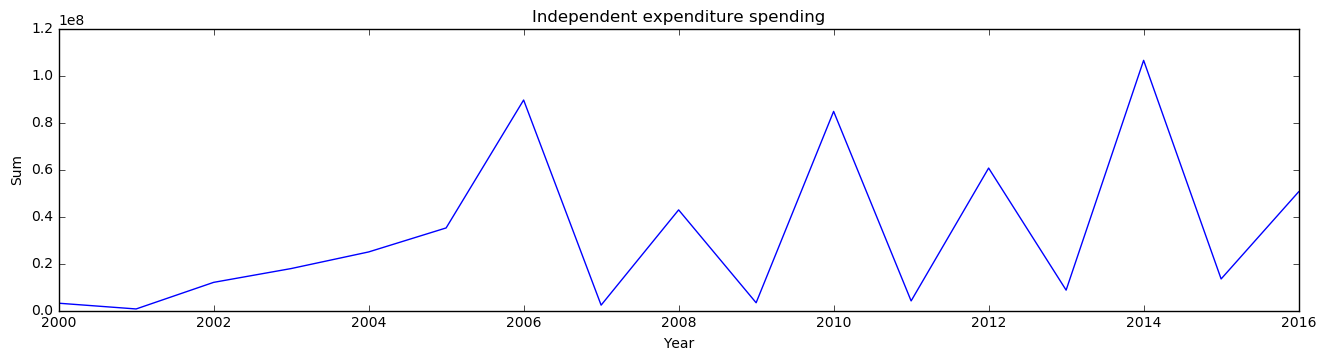

In [31]:
fig = plt.figure(1, figsize=(16,8))
ax1 = fig.add_subplot(211)
ax1.plot(by_year['year'], by_year['sum'])
ax1.set_title('Independent expenditure spending')
ax1.set_xlabel('Year')
ax1.set_ylabel('Sum')

### Spending by month

In [18]:
def trim_to_month(row):
    try:
        return datetime(year=row['EXP_DATE'].year, month=row['EXP_DATE'].month, day=1)
    except TypeError:
        return pandas.NaT

df["month"] = df.apply(trim_to_month, axis=1) 

In [24]:
by_month = df.groupby('month')['AMOUNT'].agg('sum')

In [25]:
by_month = by_month.to_frame('sum').reset_index()

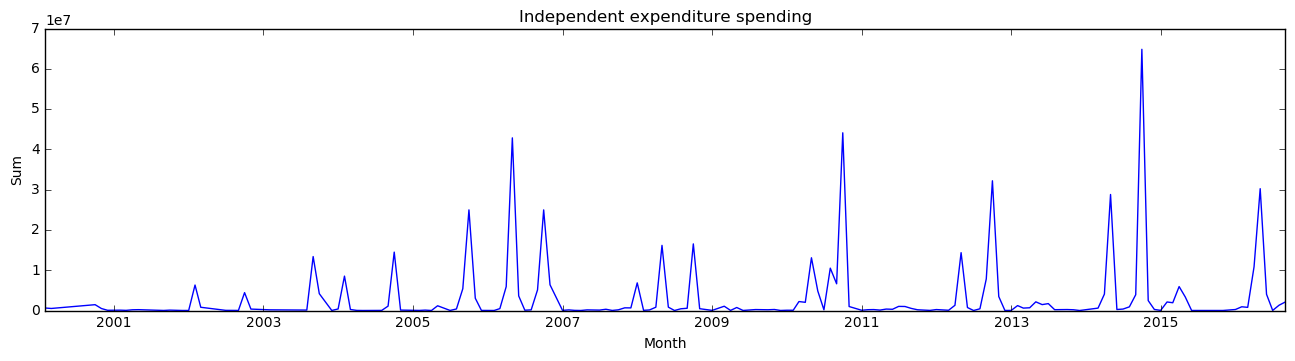

In [27]:
fig = plt.figure(1, figsize=(16,8))
ax1 = fig.add_subplot(211)
ax1.plot(by_month['month'], by_month['sum'])
ax1.set_title('Independent expenditure spending')
ax1.set_xlabel('Month')
ax1.set_ylabel('Sum')